In [ ]:
# verifying I have the latest version of tf
#!pip install --upgrade tensorflow
#!mkdir data
# downloading the weights for my model
#!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# YOLOv3 Network

In [ ]:
import numpy as np
import pandas as pd
import cv2, os, glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Concatenate, Conv2D,
    Input, Lambda, LeakyReLU,
    MaxPool2D, UpSampling2D, ZeroPadding2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.utils import plot_model

print('Libraries imported.')

Libraries imported.


In [ ]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

yolo_anchors = np.array([
    (10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
    (59, 119), (116, 90), (156, 198), (373, 326)],
    np.float32) / 416

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

class_names = [
    'person', 'bicycle','car','motorbike','aeroplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench',
    'bird','cat','dog','horse','sheep','cow','elephant','bear','zebra',
    'giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
    'skis','snowboard','sports ball','kite','baseball bat','baseball glove',
    'skateboard','surfboard','tennis racket','bottle','wine glass','cup',
    'fork','knife','spoon','bowl','banana','apple','sandwich','orange',
    'broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa',
    'pottedplant','bed','diningtable','toilet','tvmonitor','laptop','mouse',
    'remote','keyboard','cell phone','microwave','oven','toaster','sink',
    'refrigerator','book','clock','vase','scissors','teddy bear',
    'hair drier','toothbrush'
]

In [ ]:
def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLOV3_LAYER_LIST
    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)
    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

In [ ]:
# drawing bounding boxes, class names and their probabilities on the output images
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img


In [ ]:
# simple normalization of the images by a given size
# to be done at the beginning of a prediction
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

In [ ]:
# layer for Batch Normalization -> faster and more stable
# REMEMBER: here I do not train anything
class BatchNormalization(tf.keras.layers.BatchNormalization):
    def call(self, x, training = False):
        if training is None:
            traininig = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [ ]:
# definition of a single convolutional layer with three stages:
# 1. convolution
# 2. detector -> activation function
# 3. padding to be set before
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    # 3
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    #1
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    # 2
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

# darknet_block = 1 darknet_conv + nr. blocks darkent_residual
def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

# whole darknet model
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)


In [ ]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

In [ ]:
def yolo_boxes(pred, anchors, classes):
    '''pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))'''
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, objectness, class_probs, pred_box

def yolo_nms(outputs, anchors, masks, classes):
    '''boxes, conf, type'''
    b, c, t = [], [], []
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))
    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)
    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores,
            (tf.shape(scores)[0], -1, tf.shape(scores)[-1])
        ),
        max_output_size_per_class=100,
        max_total_size = 100,
        iou_threshold = 0.5,
        score_threshold = 0.5
    )
    return boxes, scores, classes, valid_detections


In [ ]:
# here is the definition of my model as the sum of all its previously-declared
# components
def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])
    x_36, x_61, x = Darknet(name='yolo_darknet')(x)
    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)
    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)
    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)
    if training:
      return Model(inputs, (output_0, output_1, output_2), name='yolov3')
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)
    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))
    return Model(inputs, outputs, name='yolov3')


In [ ]:
# some directories in my Drive
start_dir = '/content/drive/My Drive/Colab Notebooks/NN/'
model_dir = start_dir + 'model/'
# directpries for original images ...
img_dir = start_dir + 'images_original/images_input/'
res_dir = start_dir + 'images_original/images_output/'
# ... and for the downloaded YOLO weights
data_dir = start_dir + 'data/'

In [ ]:
# creating the models, I have a total of 80 classes (all contained in the
# 'class_names' array)
yolo = YoloV3(classes = 80)
yolo.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input_51[0][0]                   
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, None, None, 5 11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, None, None, 2 2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

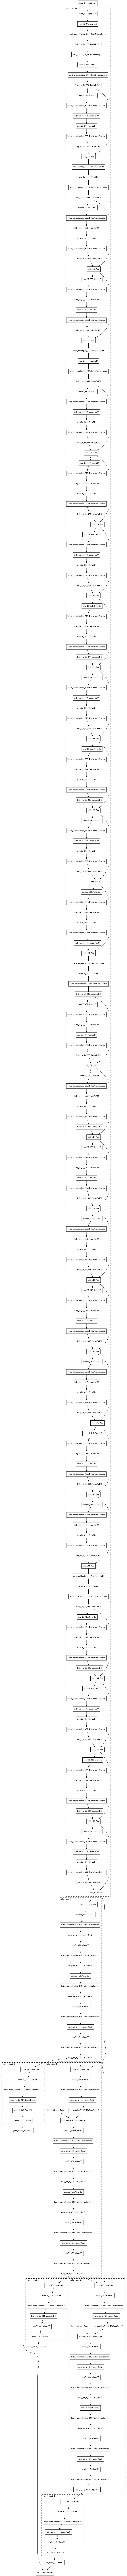

In [ ]:
# let's have a look at the model
plot_model(
    yolo, rankdir = 'TB',
    to_file = model_dir + 'yolo_model.png',
    show_shapes = False,
    show_layer_names = True,
    expand_nested = True
)

In [ ]:
# transfer learning -> initialize my model with the pre-trained weights
load_darknet_weights(yolo, data_dir +'yolov3.weights')
print('Weights loaded.')

Weights loaded.


In [ ]:
# prediction function
def predict(image_file, save_path, visualize = True, figsize = (16, 16)):
    img = tf.image.decode_image(open(image_file, 'rb').read(), channels=3)
    img = tf.expand_dims(img, 0)  # [1, img_size.width, img_size.height, img_size.depth]
    img = transform_images(img, 416)  # pre-processing data
    # main work done here by the model
    boxes, scores, classes, nums = yolo.predict(img)
    img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    if visualize:
        fig, axes = plt.subplots(figsize = figsize)
        plt.imshow(img)
        plt.savefig(save_path)
        plt.show()
    return boxes, scores, classes, nums

## YOLOv3 predictions on provided images

In [ ]:
# getting original images
image_file = glob.glob(img_dir + '*')
images = len(image_file)

print('Loaded %d images.' %(images))

Loaded 10 images.


In [ ]:
# iterating over the images and saving detections
for i in range(images):
  img_title = image_file[i][len(img_dir):]
  #print(img_title)
  boxes, scores, classes, nums = predict(image_file[i], save_path=res_dir+img_title, figsize = (20, 20))
  print('Saved image at', res_dir + img_title)

Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_original/images_output/podgorze_2019-08-13_16-00.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_original/images_output/all_saints_2019-11-17_15-00.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_original/images_output/wawel_2019-03-24_16-00.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_original/images_output/wawel_2018-09-02_17-00.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_original/images_output/grodzka_2019-08-15_14-00.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_original/images_output/wawel_2016-09-28_14-00.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_original/images_output/grodzka_2019-07-02_09-00.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_original/images_output/grodzka_2019-05-04_14-00.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_o

Let's have a look at the YOLOv3 outputs.

In [ ]:
# getting output images
image_file = glob.glob(res_dir + '*')
images = len(image_file)

print('Loaded %d images.' %(images))

for i in range(images):
  fig = plt.subplots(figsize=(10,10))
  img_title = image_file[i][len(img_dir):]
  image = mpimg.imread(res_dir + img_title)
  plt.gca().clear()
  plt.imshow(image);
  display.display(plt.gcf())
  display.clear_output(wait=True)

Output hidden; open in https://colab.research.google.com to view.

## YOLOv3 predictions on test images

This work has been extended to cover some of the most touristic locations of populated cities in Europe. Here I propose:


*   Amsterdam, Dam Square
*   Barcelona, La Rambla
* Berlin, Brandenburg Gate
* London, Trafalgar Square
* Paris, Louvre Museum
* Rome, Colosseum


In [ ]:
test_dir = '/content/drive/My Drive/Colab Notebooks/NN/images_test/'

city = 'rome' # 'amsterdam', 'barcelona', 'berlin', 'london', 'paris', 'rome'
city_dir = test_dir +  city + '/'
pc_dir = city_dir + 'pre_covid/'
dc_dir = city_dir + 'during_covid/'
save_dir = city_dir + 'results/'
data_dir = city_dir + 'data/'

In [ ]:
# getting test images
image_file = glob.glob(dc_dir + '*')
images = len(image_file)

print('Loaded %d images.' %(images))

Loaded 3 images.


In [ ]:
# iterating over the images and saving detections
for i in range(images):
  img_title = image_file[i][len(pc_dir):]
  #print(img_title)
  boxes, scores, classes, nums = predict(image_file[i], save_path=save_dir+img_title, figsize = (20, 20))
  print('Saved image at', save_dir + img_title)

Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_test/rome/results/id/rome_2020-03-07.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_test/rome/results/id/rome_2020-03-05.jpg
Saved image at /content/drive/My Drive/Colab Notebooks/NN/images_test/rome/results/id/rome_2020-03-08.jpg




Let's have a look at the YOLOv3 outputs.


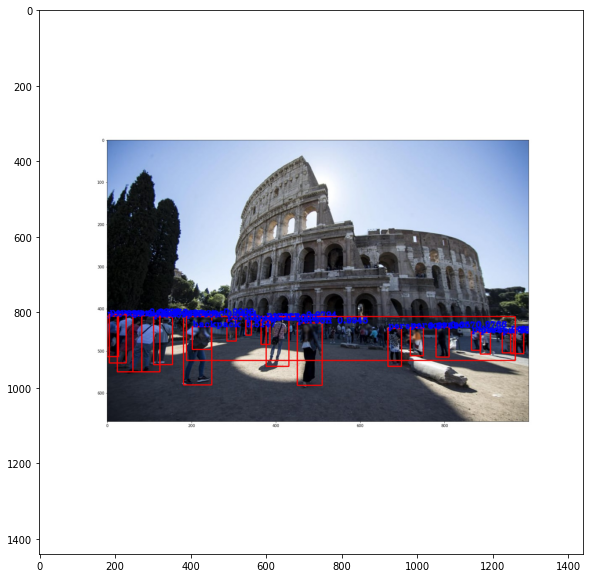

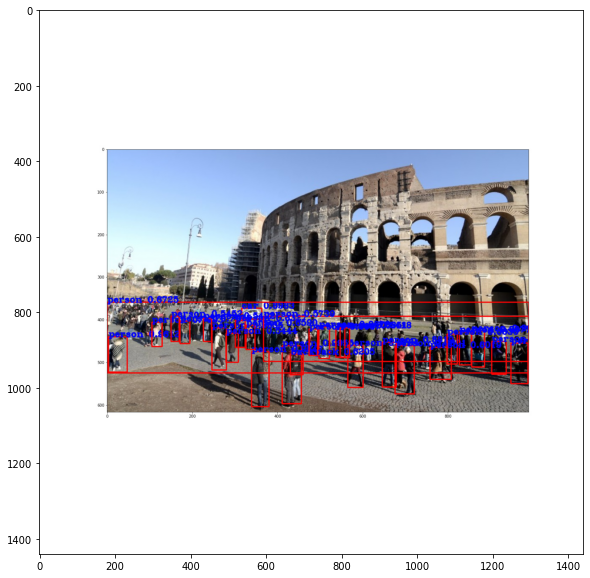

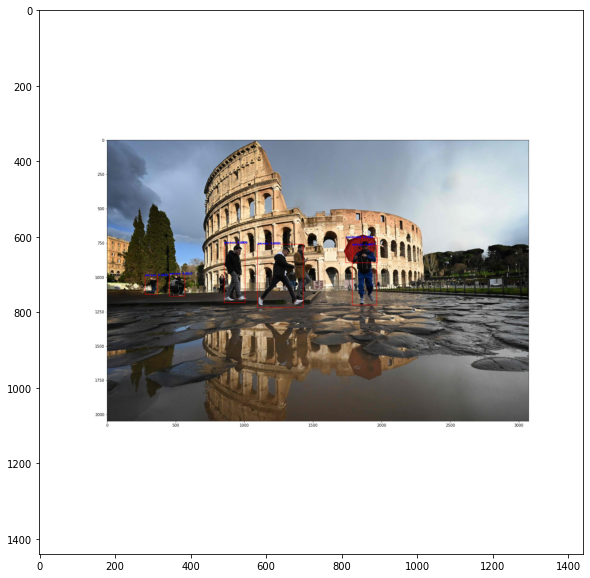

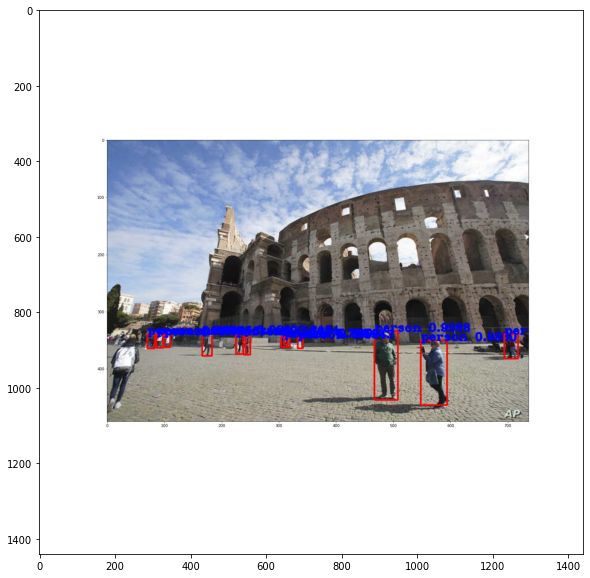

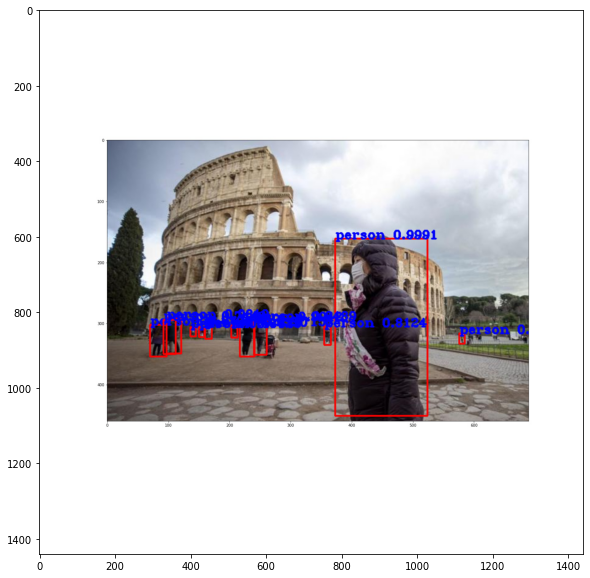

In [ ]:
# getting output images
image_file = glob.glob(save_dir + '*')
images = len(image_file)

print('Loaded %d images.' %(images))

for i in range(images):
  fig = plt.subplots(figsize=(10,10))
  img_title = image_file[i][len(save_dir):]
  image = mpimg.imread(save_dir + img_title)
  plt.gca().clear()
  plt.imshow(image);
  display.display(plt.gcf())
  display.clear_output(wait=True)